In [3]:
import os
import os.path as op
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import moss
from moss import glm
import glob
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.io as sio
import scipy.stats
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

#R stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex')

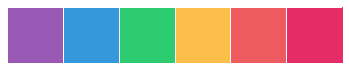

In [4]:
sub_list = ['23','24','25','26','27','28','30','31','32','35','36','37','39','40']
nruns = 6
home_dir = '/Users/ianballard/Dropbox/rule_learning/'
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

In [10]:
psych_regressor = 'kl'
mask = home_dir + 'masks/caudate_dlpfc_conn+tlrc.HEAD'
roi_name = 'caudate_exec'

In [3]:
#extract data
for sub in sub_list: 
    sub_dir = op.join(home_dir, 'mri_data', 'rule_learning_' + sub ,'brik') +'/'
    cmd = ['3dmaskave',
           '-mask', mask,
           '-quiet',
           sub_dir + 'all_runs.rule_learning_' + sub + '+tlrc.BRIK', 
           '>',
           sub_dir + roi_name + '_avg_ian.1D']
    os.system(' '.join(cmd))
    
    roi_ts = np.loadtxt(sub_dir + roi_name + '_avg_ian.1D')
    tr_starts = np.loadtxt(sub_dir + 'TR_starts.txt').astype(int)
    tr_starts = np.concatenate((tr_starts,[len(roi_ts)+1]))

    for run in range(nruns):
        #extract roi data
        run_data = roi_ts[tr_starts[run]:tr_starts[run+1]]
        run_data[0:4]=100 #deal with initial transients
        out_f1 = sub_dir + roi_name + '_run_' + str(run + 1) + '.1D'
        np.savetxt(out_f1,run_data, newline=" ")

        #detrend
        out_f2 = sub_dir + roi_name + '_detrend_run_' + str(run + 1) + '.1D' 
        cmd = ['3dDetrend',
               '-polort','3',
               '-prefix',out_f2,
               out_f1]
        os.system(' '.join(cmd))

In [5]:
def load_nuisance(sub,sub_dir,len_timeseries):
    #load the first TR
    tr_starts = op.join(sub_dir,'TR_starts.txt')
    tr_starts = np.loadtxt(tr_starts).astype(int)
    tr_starts = np.concatenate((tr_starts,[len_timeseries]))

    #load artefacts file
    censor = op.join(sub_dir,'censor_rule_learning_' + sub + '_combined_2.1D')
    censor = np.loadtxt(censor)
    censor = [int(1 - x) for x in censor] #flip sign

    #load motion file
    motion = op.join(sub_dir,'motion_demean.1D')
    motion = np.loadtxt(motion)

    return censor, motion, tr_starts

In [6]:
def regress_other_conds(data, sub_dir, run, censor, motion, tr_starts):
    cue_onsets = load_onsets(sub_dir,'cue')
    resp_onsets = load_onsets(sub_dir,'response')
    ntrials = len(cue_onsets[run])
    
    #get nuisance data
    run_censor = censor[tr_starts[run]:tr_starts[run+1]]
    run_motion = motion[tr_starts[run]:tr_starts[run+1]]

    #upsample nuisance data
    censor_interp = np.repeat(run_censor,2)
    motion_interp = []
    for col in run_motion.T:
        cs = scipy.interpolate.CubicSpline(range(len(col)),col)
        interp = cs(np.arange(0,len(col),.5))
        motion_interp.append(interp)
    motion_interp = np.array(motion_interp).T
    
    #load reaction times
    rts = rt.loc[(int(sub),int(run))].values
    rts = rts - np.nanmean(rts)
    rts[np.isnan(rts)] = 0
    
    #build design
    design = pd.DataFrame({'condition':['cue']*ntrials + ['response']*ntrials + ['rt']*ntrials,
                           'onset': list(cue_onsets[run]) + list(resp_onsets[run]) + list(resp_onsets[run]),
                           'duration': [0]*ntrials + [0]*ntrials + [0]*ntrials,
                           'value': [1.0]*ntrials + [1.0]*ntrials + list(rts)
                     })

    #convolve 
    tr = 1
    hrf = glm.GammaDifferenceHRF(tr = tr, temporal_deriv=True)
    ntp = len(data)
    model = glm.DesignMatrix(design = design, 
                             tr = tr, 
                             ntp = ntp, 
                             hrf_model = hrf,
                             hpf_cutoff = None,
                             artifacts = censor_interp,
                             confounds = motion_interp
                            )
    design = model.design_matrix.reset_index()


    #detrend
    main_cols = model.design_matrix.columns.values[model.main_vector.flatten()]
    for c in main_cols:
        polyfit = np.polyfit(design['frametimes'],
                           design[c],
                           3)
        predicted = np.polyval(polyfit, design['frametimes'])
        design[c] = design[c] - predicted
    
    #regress
    design['data'] = data
    model_str = 'data ~ 1 +' + ('+').join(model.design_matrix.columns.values)
    ols = smf.ols(model_str,data = design).fit()
    return ols.resid.values, design

In [7]:
def load_onsets(sub_dir, condition):
    o = np.loadtxt(op.join(sub_dir,condition + '_onsets'))
    onsets = {}
    for run,row in enumerate(o):
        onsets[run] = row
    return onsets

In [8]:
#deal with RT data
rt = pd.read_csv(home_dir + '/behavioral_data_rt.csv')
run_to_cond = {1:'A and B',2:'(A and B) or C',3:'A or B',4:'A',5:'A xor B',6:'(A or B) and C'}
cond_to_run = {x:y for y,x in run_to_cond.iteritems()}
rt['run'] = [cond_to_run[x] - 1for x in rt['condition']]
rt['rt'] = [np.log(x) for x in rt['rt']] #log-transform
rt = rt.set_index(['sub','run'])['rt'].sort_index()

In [11]:
df = {'signal':[],'trial':[],'sub':[],'run':[], 'lag':[]}

for sub in sub_list:
    sub_dir = op.join(home_dir, 'mri_data', 'rule_learning_' + sub ,'brik')
    cond_onsets = load_onsets(sub_dir,'feedback')

    run_ts = np.loadtxt(sub_dir + '/' + roi_name + '_avg_ian.1D')
    censor, motion, tr_starts = load_nuisance(sub,sub_dir, len(run_ts))
    
    for run in range(nruns):
        #load data
        out_f2 = op.join(sub_dir,roi_name + '_detrend_run_' + str(run + 1) + '.1D')
        data = np.loadtxt(out_f2)

        #upsample to one second
        cs = scipy.interpolate.CubicSpline(range(len(data)),data)
        data = cs(np.arange(0,len(data),.5))
        
        #regress out cue and response periods
        cleaned_data, model = regress_other_conds(data, sub_dir, run, censor, motion, tr_starts)
        
        #loop through lags
        for lag in range(12):
            onsets = [int(x) + lag for x in cond_onsets[run]]
            while onsets[-1] >= len(cleaned_data):
                cleaned_data = np.hstack([cleaned_data,np.NaN])
            signal = cleaned_data[onsets]

            df['signal'].extend(signal)
            df['trial'].extend(range(len(signal)))
            df['sub'].extend([sub]*len(signal))
            df['run'].extend([run]*len(signal))
            df['lag'].extend([lag]*len(signal))

df = pd.DataFrame(df).dropna()

In [12]:
df = df.dropna()

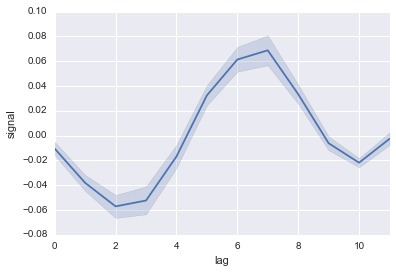

In [13]:
fig_df = df.groupby(['sub','lag']).mean().reset_index()
sns.tsplot(time = 'lag',value = 'signal',unit = 'sub',data = fig_df)

In [14]:
df['condition'] = [run_to_cond[x+1] for x in df['run']]

In [15]:
#load behavioral data
behav = pd.read_csv(home_dir + '/behavioral_data.csv')
model = behav[behav['sub'] == 'model'].copy() #bayesian model
behav = behav[behav['sub'] != 'model']
behav['hit'] = np.NaN
behav = behav.set_index(['sub','condition','trial']).sort_index()

#calculate surprise
model['surprise'] = [1 - x for x in model['hits']]
model = model.set_index(['condition','trial']).sort_index()

#load RL PE
rl = pd.read_csv(home_dir + 'rl_predictions_PH.csv')
rl = rl.set_index(['condition','trial']).sort_index()


In [16]:
df = df.set_index(['sub','condition','trial']).sort_index()

In [17]:
#enter information about condition, RL PE, and surprise
for row in set(behav.index):
    hit = behav.loc[row,'hits']
    pe = rl.loc[row[1:],'pe']
    surprise = model.loc[row[1:],'surprise']

    df.loc[row,'hit'] = hit
    df.loc[row,'pe'] = pe
    df.loc[row,'surprise'] = surprise

df = df.reset_index()

In [18]:
hit_map = {0:'Incorrect',1:'Correct'}

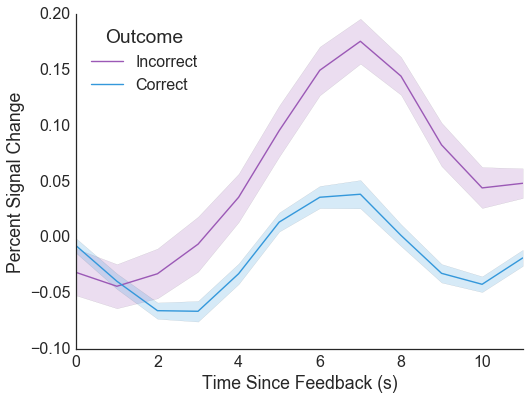

In [18]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (8, 6)})
sns.set_style("white")
fig_df = df.groupby(['sub','lag','hit']).mean().reset_index()
fig_df['Outcome'] = [hit_map[x] for x in fig_df['hit']]
sns.tsplot(time = 'lag',value = 'signal',unit = 'sub',condition = 'Outcome',
           data = fig_df,color = sns.color_palette(flatui))
sns.despine()
plt.ylabel('Percent Signal Change')
plt.xlabel('Time Since Feedback (s)')
plt.savefig('../figures/revision/striatum_BOLD.svg',dpi=600)

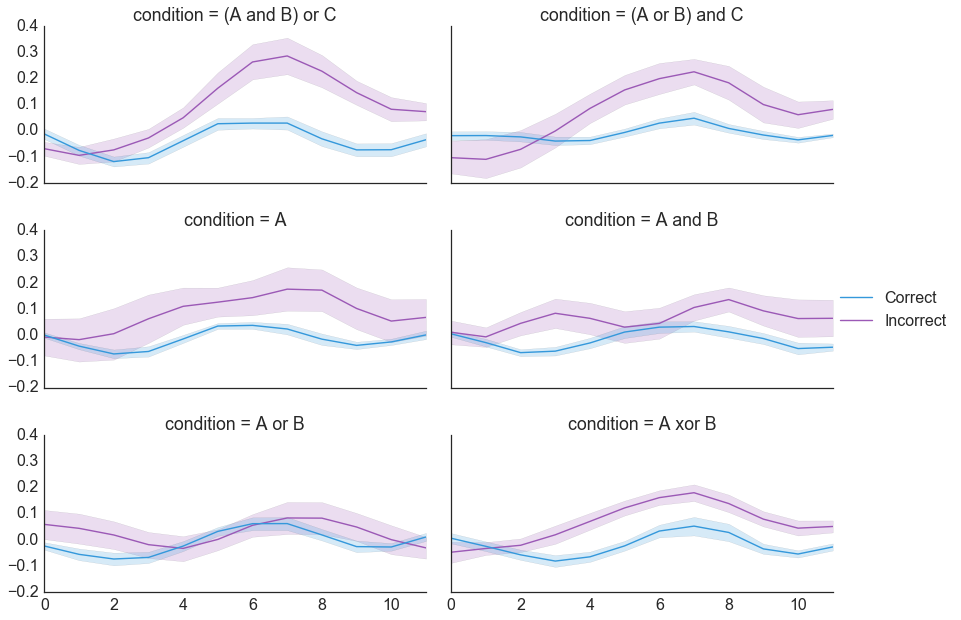

In [89]:
fig_df = df.groupby(['sub','lag','hit','condition']).mean().reset_index()
fig_df['Outcome'] = [hit_map[x] for x in fig_df['hit']]
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(fig_df, col='condition',col_wrap = 2, aspect = 2)
g.map_dataframe(sns.tsplot, time="lag", unit="sub",
                value="signal", condition = 'Outcome',color = sns.color_palette(flatui)).add_legend()
plt.savefig('../figures/revision/outcome_by_condition.png',dpi=600)

In [19]:
def split_chunks(x,param):
    if x < np.percentile(df[param], 33):
        return 'low',0
    elif x < np.percentile(df[param], 66):
        return 'medium',1
    else:
        return 'high',2

In [20]:
df['pe_split'] = [split_chunks(x,'pe')[0] for x in df['pe']]
df['pe_split_tercile'] = [split_chunks(x,'pe')[1] for x in df['pe']]

In [21]:
df['surprise_split'] = [split_chunks(x,'surprise')[0] for x in df['surprise']]
df['surprise_split_tercile'] = [split_chunks(x,'surprise')[1] for x in df['surprise']]

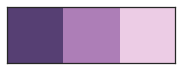

In [22]:
pal_kws = dict(start=0, light=.3, dark=.85)
palette = sns.cubehelix_palette(3, rot=.2, **pal_kws)
sns.palplot(palette)

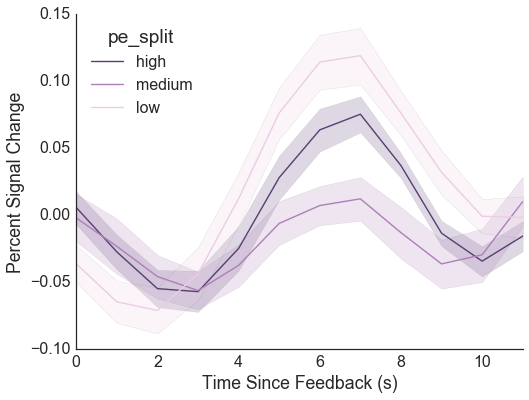

In [23]:
fig_df = df.groupby(['sub','lag','pe_split']).mean().reset_index()
fig_df = fig_df.sort_values(by = 'pe_split_tercile', ascending = False)
sns.tsplot(time = 'lag',
           value = 'signal',
           unit = 'sub',
           condition = 'pe_split',
           data = fig_df,
           color = palette,)
sns.despine()
plt.ylabel('Percent Signal Change')
plt.xlabel('Time Since Feedback (s)')
plt.savefig('../figures/revision/pe_striatum.svg',bbox_inches = 'tight',dpi=300)

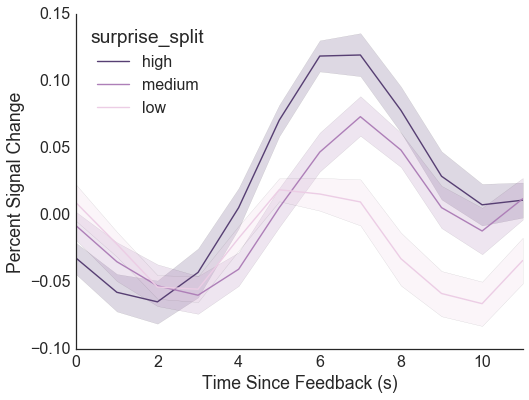

In [24]:
fig_df = df.groupby(['sub','lag','surprise_split']).mean().reset_index()
fig_df = fig_df.sort_values(by = 'surprise_split_tercile', ascending = False)
sns.tsplot(time = 'lag',
           value = 'signal',
           unit = 'sub',
           condition = 'surprise_split',
           data = fig_df,
           color = palette)
sns.despine()
plt.ylabel('Percent Signal Change')
plt.xlabel('Time Since Feedback (s)')
plt.savefig('../figures/revision/surprise_striatum.svg',bbox_inches = 'tight',dpi=300)

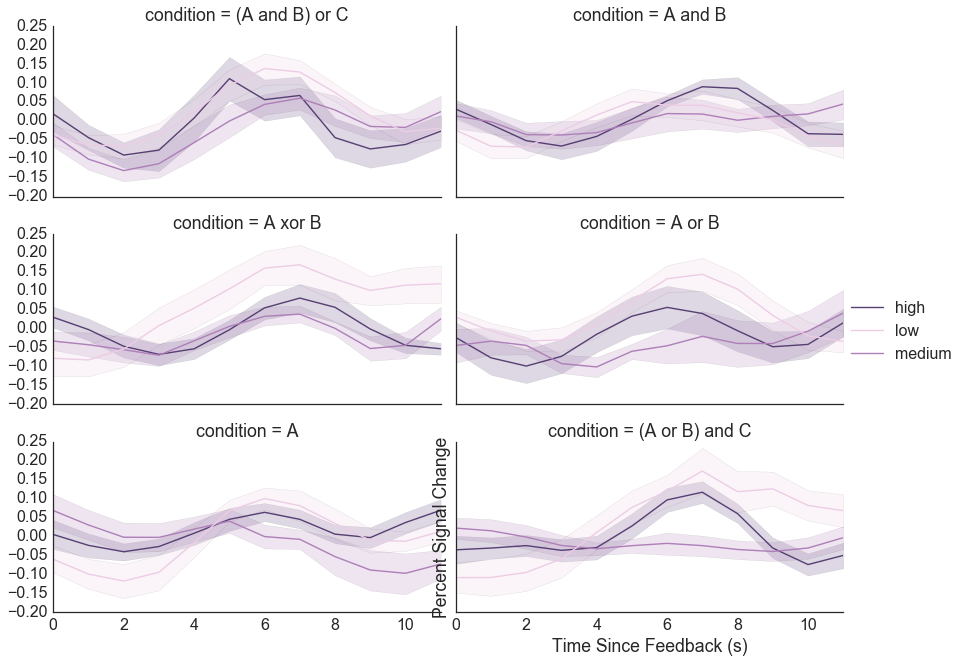

In [358]:
fig_df = df.groupby(['sub','lag','pe_split','condition']).mean().reset_index()
fig_df = fig_df.sort_values(by = ['pe_split_tercile'], ascending = False)
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(fig_df, col='condition',col_wrap = 2, aspect = 2)
g.map_dataframe(sns.tsplot, time="lag", unit="sub",
                value="signal", condition = 'pe_split',color = palette).add_legend()
sns.despine()
plt.ylabel('Percent Signal Change')
plt.xlabel('Time Since Feedback (s)')
plt.savefig('../figures/revision/pe_striatum_condition.png',dpi=300)

In [53]:
#now do terciles by condition
df = df.reset_index().set_index('condition').sort_index()
for cond in set(df.index):
    df.loc[cond, 'surprise_split_cond'] = np.array([split_chunks(x,'surprise')[0] for x in df.loc[cond,'surprise']])
    df.loc[cond,'surprise_split_tercile_cond'] = np.array([split_chunks(x,'surprise')[1] for x in df.loc[cond,'surprise']])
df = df.reset_index()

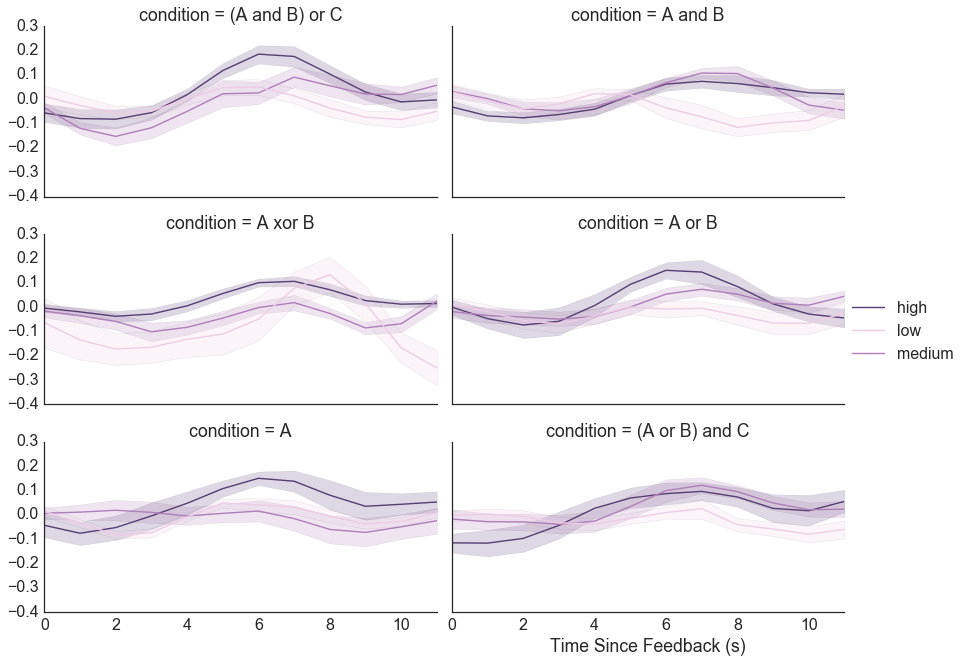

In [54]:
fig_df = df.groupby(['sub','lag','surprise_split_cond','condition']).mean().reset_index()
fig_df = fig_df.sort_values(by = ['surprise_split_tercile_cond'], ascending = False)
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(fig_df, col='condition',col_wrap = 2, aspect = 2)
g.map_dataframe(sns.tsplot, time="lag", unit="sub",
                value="signal", condition = 'surprise_split_cond',color = palette).add_legend()
sns.despine()
plt.xlabel('Time Since Feedback (s)')
plt.savefig('../figures/revision/surprise_striatum_condition.svg',dpi=600)

In [110]:
def remove_intercept_variance(x, group_mean):
    return x - x.mean() + group_mean

In [20]:
#get peak response
evoked = df[df['lag'] >=5]
evoked = evoked[evoked['lag'] <=8]
evoked = evoked.groupby(['sub','condition','trial']).mean().reset_index()
evoked = evoked.sort_values(by = ['sub','condition','trial'])

In [35]:
evoked = moss.remove_unit_variance(evoked, 'signal', 'sub', group='condition', suffix="_within")

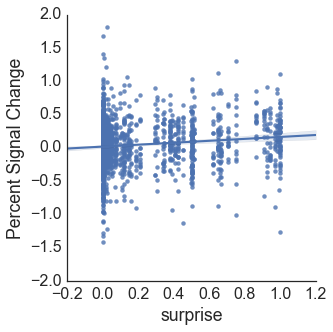

In [38]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (8, 6)})
sns.set_style("white")
g = sns.lmplot(x="surprise", y="signal_within", units = 'sub',
               robust = True,data=evoked,palette = flatui)
sns.despine()
plt.ylabel('Percent Signal Change')
plt.savefig('../figures/revision/surprise_striatum_parametric.png',dpi=600)

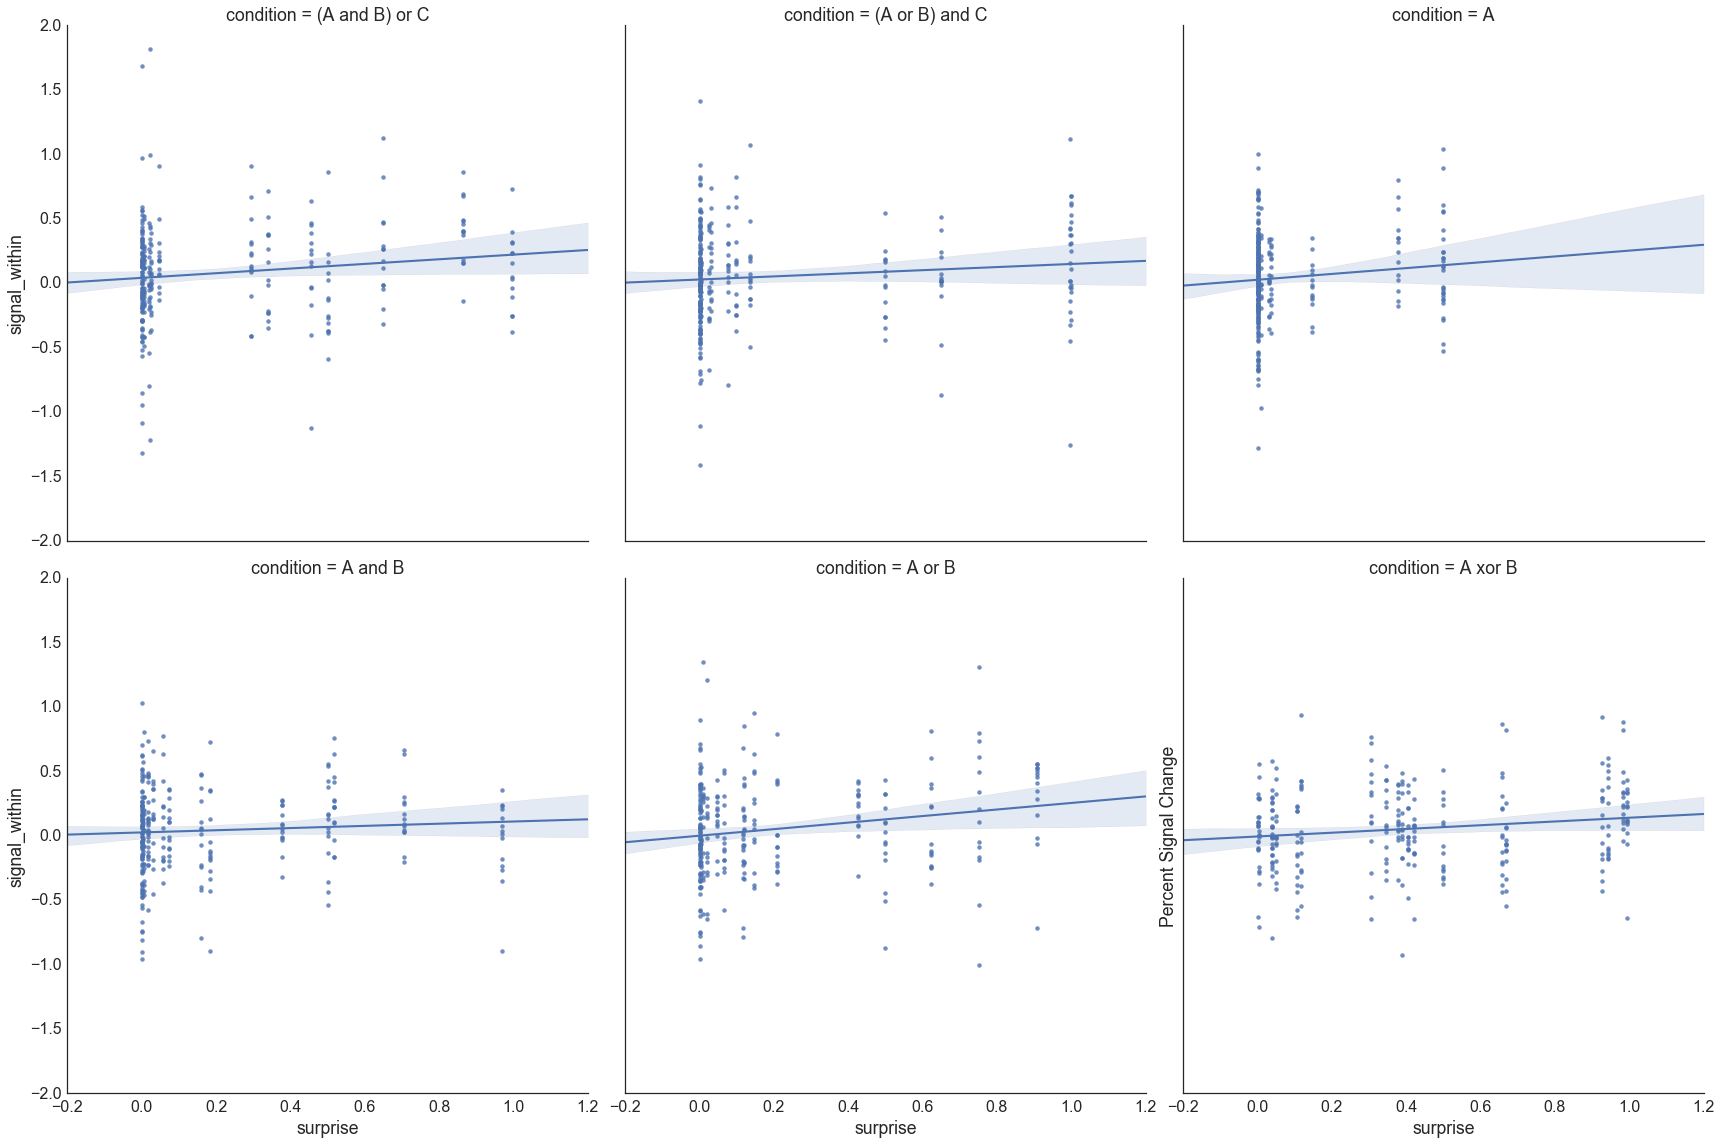

In [60]:
g = sns.lmplot(x="surprise", y="signal_within", col="condition",units = 'sub',
               robust = True,
               data=evoked, col_wrap=3, size=8,
              palette = flatui)
sns.despine()
plt.ylabel('Percent Signal Change')
plt.savefig('../figures/revision/surprise_striatum_condition_parametric.svg',dpi=600)

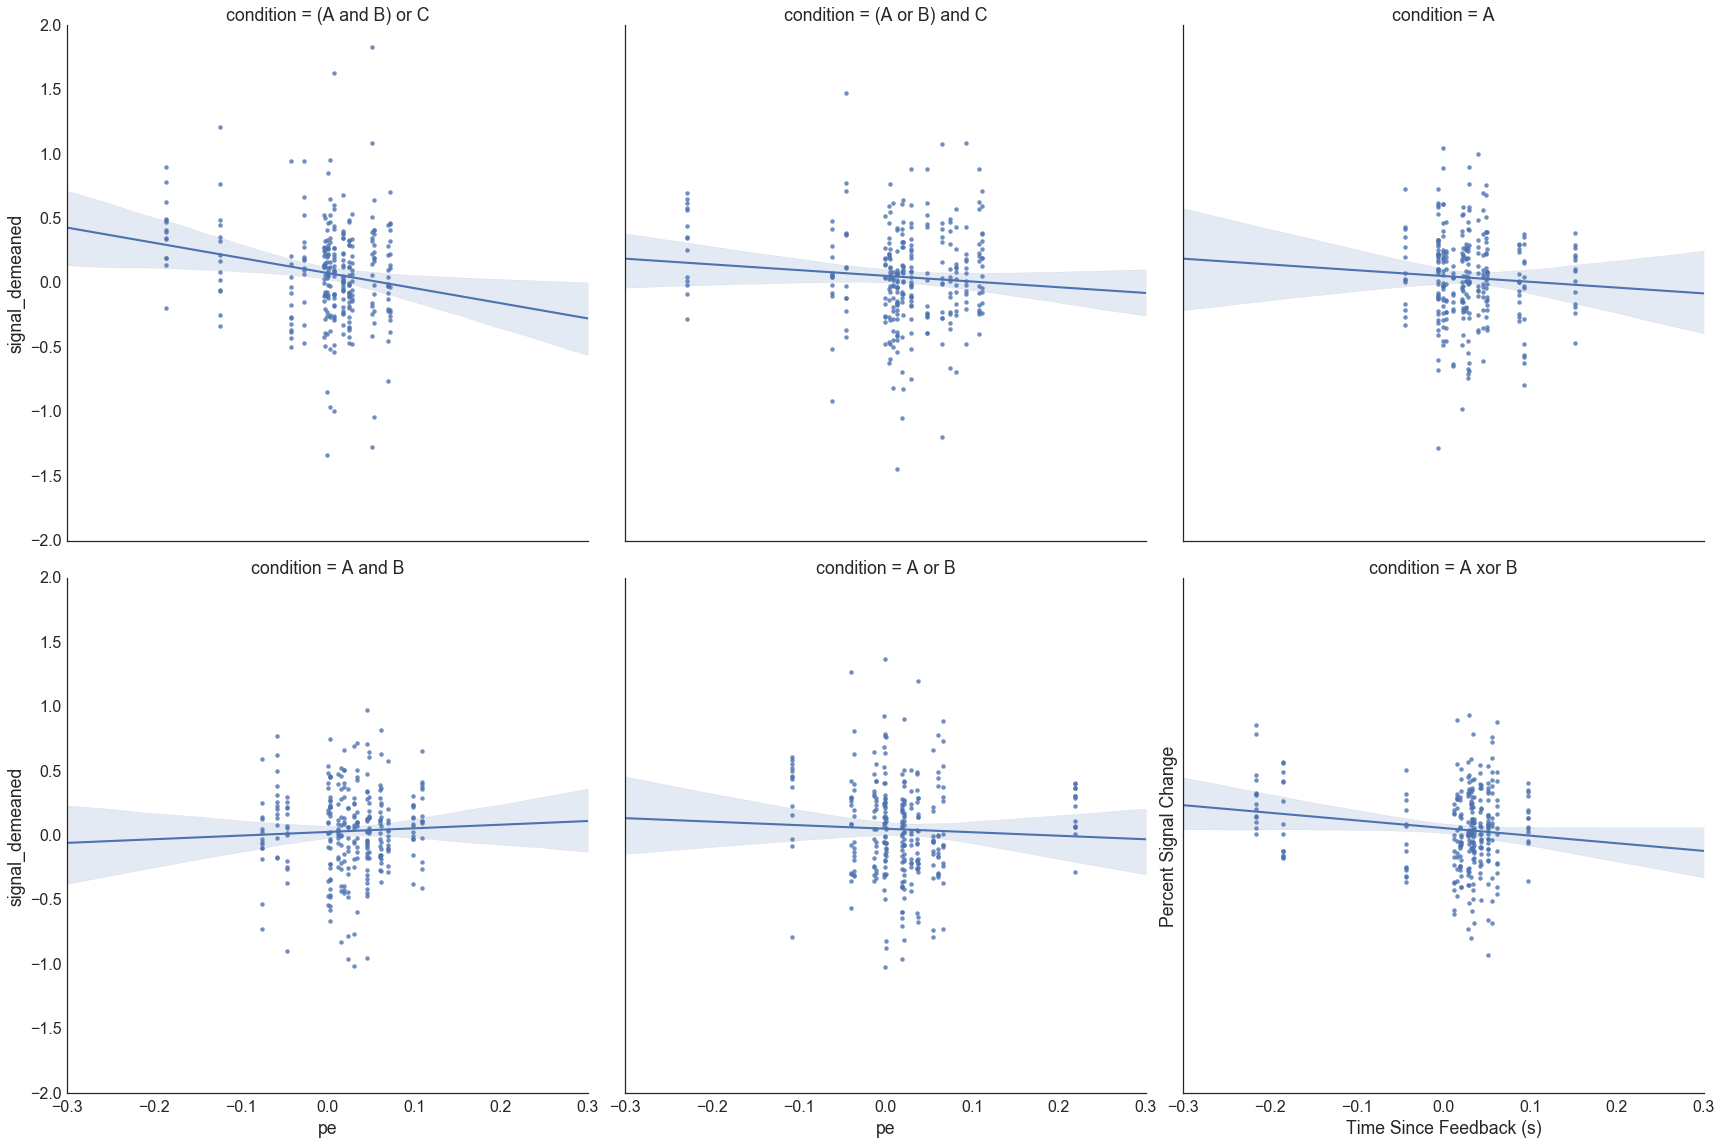

In [299]:
g = sns.lmplot(x="pe", y="signal_demeaned", col="condition",units = 'sub',
               data=evoked, col_wrap=3, size=8, robust = False)
sns.despine()
plt.ylabel('Percent Signal Change')
plt.xlabel('Time Since Feedback (s)')
plt.savefig('../figures/revision/pe_striatum_condition_parametric.png',dpi=300)

In [29]:
evoked = evoked.sort_values(by = 'condition', ascending = False)
model_str = 'signal ~ hit'
mixedfx = smf.mixedlm(model_str, evoked, groups = evoked['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 1680    Method:             REML     
No. Groups:       14      Scale:              0.1246   
Min. group size:  120     Likelihood:         -640.2800
Max. group size:  120     Converged:          Yes      
Mean group size:  120.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.143    0.019  7.627 0.000  0.106  0.180
hit          -0.119    0.021 -5.613 0.000 -0.160 -0.077
Intercept RE  0.000    0.002                           



//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [33]:
# evoked = evoked.reset_index()
evoked['surprise_demean'] = evoked['surprise'] - evoked['surprise'].mean()
evoked['pe_demean'] = evoked['pe'] - evoked['pe'].mean()
evoked['cond'] = evoked['condition']
rename ={'A and B':'A and B',
         '(A and B) or C':'(A and B) or C',
         'A or B':'A or B',
         'A':'A',
         'A xor B': 'A and not B or B and not A',
         '(A or B) and C':'(A or B) and C'}
evoked['cond'] = [rename[x] for x in evoked['cond']]
evoked['pe_abs'] = [abs(x) for x in evoked['pe']]
evoked['pe_abs_demean'] = evoked['pe_abs'] - evoked['pe_abs'].mean()
# evoked['bayes_LL'] = evoked['bayes_LL'] - evoked['bayes_LL'].mean()

evoked = evoked.sort_values(by = 'condition', ascending = False)
model_str = 'signal ~ C(condition, Sum)*surprise_demean + C(condition, Sum)*pe_demean'
mixedfx = smf.mixedlm(model_str, evoked, groups = evoked['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              signal   
No. Observations:              1680                 Method:                          REML     
No. Groups:                    14                   Scale:                           0.1252   
Min. group size:               120                  Likelihood:                      -663.5348
Max. group size:               120                  Converged:                       Yes      
Mean group size:               120.0                                                          
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.052    0.009  5.534 0.0

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [114]:
for cond in set(evoked['condition']):
    print cond
    cond_df = evoked[evoked['condition'] == cond]

    model_str = 'signal ~ 1 + surprise'
    mixedfx = smf.mixedlm(model_str, cond_df, groups = cond_df['sub'])    
    mixedfx = mixedfx.fit()
    print mixedfx.summary()

A
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal  
No. Observations: 280     Method:             REML    
No. Groups:       14      Scale:              0.1143  
Min. group size:  20      Likelihood:         -96.8201
Max. group size:  20      Converged:          Yes     
Mean group size:  20.0                                
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.017    0.022 0.740 0.459 -0.027  0.061
surprise      0.286    0.123 2.316 0.021  0.044  0.528
Intercept RE  0.000                                   


//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



(A and B) or C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1483   
Min. group size:  20      Likelihood:         -133.6470
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.037    0.028 1.313 0.189 -0.018  0.091
surprise       0.190    0.074 2.572 0.010  0.045  0.335
Intercept RE   0.000    0.034                          

A or B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1405   
Min. group size:  20      Likelihood:     

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A and B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal  
No. Observations: 280     Method:             REML    
No. Groups:       14      Scale:              0.1089  
Min. group size:  20      Likelihood:         -90.5843
Max. group size:  20      Converged:          Yes     
Mean group size:  20.0                                
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.021    0.024 0.875 0.382 -0.026  0.067
surprise      0.079    0.072 1.106 0.269 -0.061  0.220
Intercept RE  0.000                                   

(A or B) and C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1413   
Min. group size:  20      Likelihood:         -126.95

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A xor B
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: signal  
No. Observations:  280     Method:             REML    
No. Groups:        14      Scale:              0.0980  
Min. group size:   20      Likelihood:         -76.1064
Max. group size:   20      Converged:          Yes     
Mean group size:   20.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.014    0.030 -0.477 0.633 -0.072  0.044
surprise      0.160    0.055  2.888 0.004  0.051  0.268
Intercept RE  0.000                                    



In [300]:
for cond in set(evoked['condition']):
    print cond
    cond_df = evoked[evoked['condition'] == cond]

    model_str = 'signal ~ pe'
    mixedfx = smf.mixedlm(model_str, cond_df, groups = cond_df['sub'])    
    mixedfx = mixedfx.fit()
    print mixedfx.summary()

A
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: signal  
No. Observations:  280     Method:             REML    
No. Groups:        14      Scale:              0.1162  
Min. group size:   20      Likelihood:         -97.6886
Max. group size:   20      Converged:          Yes     
Mean group size:   20.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.053    0.025  2.122 0.034  0.004  0.102
pe           -0.449    0.482 -0.930 0.352 -1.394  0.497
Intercept RE  0.000                                    


//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



(A and B) or C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1469   
Min. group size:  20      Likelihood:         -130.6907
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.076    0.023  3.326 0.001  0.031  0.121
pe           -1.174    0.385 -3.049 0.002 -1.928 -0.419
Intercept RE  0.000    0.031                           

A or B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1441   
Min. group size:  20      Likelihood:     

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A and B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal  
No. Observations: 280     Method:             REML    
No. Groups:       14      Scale:              0.1092  
Min. group size:  20      Likelihood:         -89.1932
Max. group size:  20      Converged:          Yes     
Mean group size:  20.0                                
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.028    0.022 1.244 0.214 -0.016  0.072
pe            0.282    0.428 0.660 0.509 -0.556  1.120
Intercept RE  0.000                                   

(A or B) and C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1412   
Min. group size:  20      Likelihood:         -125.40

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A xor B
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: signal  
No. Observations:  280     Method:             REML    
No. Groups:        14      Scale:              0.0989  
Min. group size:   20      Likelihood:         -75.9346
Max. group size:   20      Converged:          Yes     
Mean group size:   20.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.058    0.019  3.076 0.002  0.021  0.096
pe           -0.591    0.250 -2.369 0.018 -1.080 -0.102
Intercept RE  0.000                                    



In [407]:
evoked = evoked.set_index(['condition','sub']).sort_index()

In [504]:
#get individual subject slopes
# evoked = evoked.set_index(['sub','condition']).sort_index()
slopes = {'sub':[],'cond':[],'error':[],'slope':[]}
for row in set(evoked.index):
    for regressor in ['surprise','pe','pe_abs']:
        model_str = 'signal ~ 1 + ' + regressor
        ols = smf.ols(model_str, evoked.loc[row]).fit()  
        
        slopes['slope'].append(ols.params[regressor])
        slopes['error'].append(regressor)
        slopes['sub'].append(int(row[0]))
        slopes['cond'].append(row[1])
slopes = pd.DataFrame(slopes)

slopes  = pd.pivot_table(slopes, values='slope', index=['sub', 'cond'],
                   columns=['error'])
slopes = slopes.reset_index()

In [505]:
#load and clean data
model_fits = pd.read_csv(home_dir + 'predictie_LL_results.csv')
model_fits = model_fits[['sub','test_cond','test_LL','model_id']]
models = ['exhaustive_PH_', 'bayes']
for m in set(model_fits['model_id']):
    if m not in models:
        model_fits = model_fits[model_fits['model_id'] != m]

#pivot models into columns
model_fits  = pd.pivot_table(model_fits, values='test_LL', index=['sub', 'test_cond'],
                   columns=['model_id'])
model_fits = model_fits.reset_index()

#probit mapping
model_fits['ll_diff'] = model_fits['bayes'] - model_fits['exhaustive_PH_']
model_fits = model_fits.rename(columns={'test_cond': 'cond'})

#merge with slopes data
model_fits = pd.merge(model_fits,
         slopes,
         on = ['sub','cond'],
        how = 'outer')

In [506]:
# bayes_results  =pd.read_csv(op.abspath('../bayes_model_LL_no_fit.csv'))
# bayes_results['sub'] = [str(sub) for sub in bayes_results['sub']]
# evoked = evoked.set_index(['sub','condition']).sort_index()
# bayes_results = bayes_results.set_index(['sub','test_cond']).sort_index()

# for row in set(evoked.index):
#     evoked.loc[row,'bayes_LL'] = bayes_results.loc[row,'test_LL']
    
# evoked = evoked.reset_index()
# bayes_results = bayes_results.reset_index()

In [507]:
# model_fits['sub'] = [str(sub) for sub in model_fits['sub']]
# evoked = evoked.set_index(['sub','condition']).sort_index()
# model_fits = model_fits.set_index(['sub','cond']).sort_index()
# for row in set(evoked.index):
#     evoked.loc[row,'ll_diff'] = model_fits.loc[row,'ll_diff']
# evoked = evoked.reset_index()
# model_fits = model_fits.reset_index()

In [514]:
model_str = 'bayes ~  C(cond, Sum)*surprise '
mixedfx = smf.mixedlm(model_str, model_fits, groups = model_fits['sub'])   
mixedfx = mixedfx.fit()
print mixedfx.summary()

                       Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          bayes  
No. Observations:            84               Method:                      REML   
No. Groups:                  14               Scale:                       0.0043 
Min. group size:             6                Likelihood:                  79.9357
Max. group size:             6                Converged:                   Yes    
Mean group size:             6.0                                                  
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.773    0.010 76.435 0.000  0.753  0.793
C(cond, Sum)[S.(A and B) or C]          -0.098    0.020 -4.852 0.000 -0.138 -0.059
C(cond, Sum)[S.(A or B) an

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


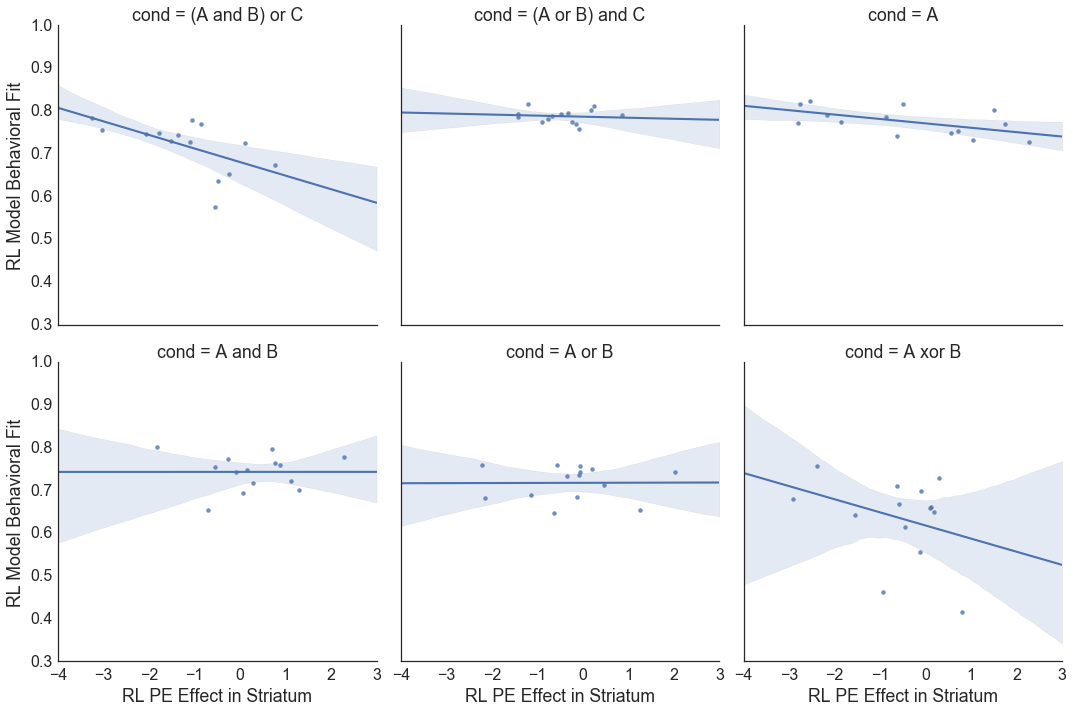

In [305]:
model_fits['exhaustive_PH_demean'] = model_fits.groupby('sub').exhaustive_PH_.transform(remove_intercept_variance,
                                                              model_fits.exhaustive_PH_.mean())

model_fits['RL Model Behavioral Fit'] = model_fits['exhaustive_PH_demean']
model_fits['RL PE Effect in Striatum'] = model_fits['pe']
g = sns.lmplot(x="RL PE Effect in Striatum", y="RL Model Behavioral Fit", col="cond",
               data=model_fits, aspect=1, col_wrap = 3,x_jitter=.1)

plt.savefig('../figures/revision/pe_striatum_condition_model_fit_relationship.png',dpi=300)

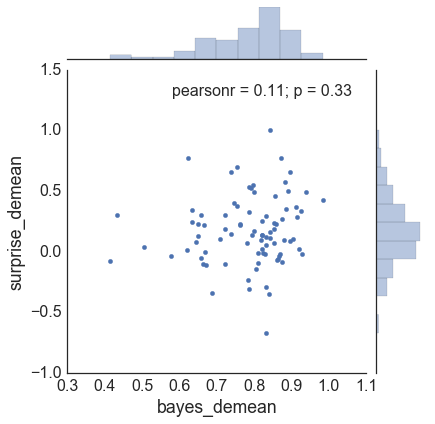

In [520]:
model_fits['bayes_demean'] = model_fits.groupby('sub').bayes.transform(remove_intercept_variance,
                                                              model_fits.bayes.mean())
model_fits['surprise_demean'] = model_fits.groupby('sub').surprise.transform(remove_intercept_variance,
                                                              model_fits.surprise.mean())
g = sns.jointplot(x="bayes_demean", y="surprise_demean", data = model_fits)
